In [1]:
from utils import *
# from raster_utils import *
import matplotlib.pyplot as plt

gps_coords = 46.500458, 8.052669
gps_lat, gps_lon = gps_coords


metadata_links = {'2m' : 'ch.swisstopo.swissalti3d-fGQ3d2A6.csv' , \
                '0.5m' : 'https://ogd.swisstopo.admin.ch/resources/ch.swisstopo.swissalti3d-3TuKAiHo.csv' }

transformer = Transformer.from_crs( 'epsg:4326', 'epsg:2056' )
swiss_topo_lon, swiss_topo_lat = transformer.transform( gps_lat, gps_lon)

filename = metadata_links['2m']
global grid_size 
grid_size = 2
radius = 3
tile_meta_df = get_tile_metadata(filename)
target_tiles = get_targets(swiss_topo_lat, swiss_topo_lon, tile_meta_df, radius)
# plot_tile_corners(target_tiles)

array, blank_array = get_tiles(target_tiles, source = 'local')

observer_pixel, observer_height = get_observer_position(array, blank_array, swiss_topo_lat, swiss_topo_lon )
peaks_df = get_peaks( array, observer_pixel, observer_height, grid_size)

array =  np.squeeze(array, axis = 0)


mdf_list, tdf_list, amdf_list = [], [], []
for month in np.arange(1,2):
    # compile data for a range of months
    year = 2021
    day = 1
    date = {'year':year,'month':month,'day':day}
    start_date = datetime.date(year = date['year'], month = date['month'], day = date['day'])
    mdf_,tdf_,amdf_  = get_data(gps_coords, observer_height, peaks_df, start_date)
    mdf_list.append(mdf_)
    tdf_list.append(tdf_)
    amdf_list.append(amdf_)

mdf = mdf_list[0]

for i, hour in enumerate( np.linspace(4, 22, 10) ):
    #   In a given day, find rows nearest interpolated hours
    id = mdf.time_since_midnight.sub( hour*60 ).abs().idxmin()
    azimuth = mdf.loc[ id, 'azimuth' ]
    az_vector = np.tan(azimuth * np.pi / 180)
    #   calculate sun exposure due to gradient
    exposure = np.arctan( np.dot( np.gradient(array, axis = 0), az_vector ) ) * 180 / np.pi
    elevation = mdf.loc[ id, 'elevation' ]
    el_vector = np.tan(elevation * np.pi / 180)


Opening tile number  0  of  20
Opening tile number  1  of  20
Opening tile number  2  of  20
Opening tile number  3  of  20
Opening tile number  4  of  20
Opening tile number  5  of  20
Opening tile number  6  of  20
Opening tile number  7  of  20
Opening tile number  8  of  20
Opening tile number  9  of  20
Opening tile number  10  of  20
Opening tile number  11  of  20
Opening tile number  12  of  20
Opening tile number  13  of  20
Opening tile number  14  of  20
Opening tile number  15  of  20
Opening tile number  16  of  20
Opening tile number  17  of  20
Opening tile number  18  of  20
Opening tile number  19  of  20
Done.
Merging ... 
Done.


In [2]:
#   Get sun angle for given time, vectorise. 
id = mdf.time_since_midnight.sub( 12*60 ).abs().idxmin()
azimuth = mdf.loc[ id, 'azimuth' ]
az_vector = get_azimuth_vector(azimuth)
elevation = mdf.loc[ id, 'elevation' ]
el_vector = np.tan(elevation * np.pi / 180)
az_vector


(0.1402426490913626, -0.9901171644688506)

In [3]:
def get_shadows(slice, inter_points, el_vector, grid_size = 2):
    dict = {'x':inter_points[:,0], 'y':inter_points[:,1], 'z':slice}
    df = pd.DataFrame.from_dict(dict)

    for index in df.index:
        difs = df.loc[index::, 'z'] - df.loc[index,'z']
        dists = df.index[index::] * grid_size
        df.loc[index, 'max_vect'] = (difs/dists).max()
        if any(difs / dists > el_vector):
            df.loc[index, 'shadow'] = True
    return df.fillna('False')

In [9]:
array.shape

(2000, 3500)

In [10]:
nrows,ncols = array.shape
x = np.arange(nrows)
y = np.arange(ncols)
points = (x, y)

array_cartesian = np.flip(array, axis=0)
radius = 8000 # m
n_steps = 100
x_vector, y_vector = get_azimuth_vector(azimuth)
slices = []
inter_points = []
df = pd.DataFrame()
for i in x:
    step = np.linspace(0, radius/grid_size, n_steps)
    x_sample =  i + step * x_vector
    y_sample =  step * -1 * y_vector
    inter_points = np.dstack((x_sample,y_sample)).squeeze(axis = 0)
    slice = interpn(points, array_cartesian, inter_points, method = 'linear', bounds_error = False, fill_value = 0 )
    df = pd.concat([df, get_shadows(slice, inter_points, el_vector)])

,x,y,z,max_vect,shadow
0,0.000000,0.000000,2669.882812,5.006054,True
1,0.708296,5.000592,2675.838824,4.796298,True
2,1.416592,10.001183,2682.907388,4.714105,True
3,2.124889,15.001775,2690.865290,4.621572,True
4,2.833185,20.002367,2694.459804,4.579775,True
...,...,...,...,...,...
95,566.288140,475.056215,0.000000,0.000000,False
96,566.996436,480.056807,0.000000,0.000000,False
97,567.704732,485.057399,0.000000,0.000000,False
98,568.413028,490.057990,0.000000,0.000000,False


In [30]:
import plotly.express as px

fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'shadow')
fig.show()

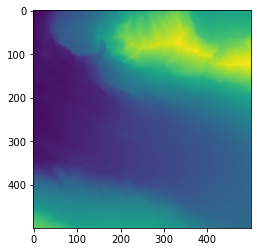

In [ ]:
plt.imshow(array_cartesian)

In [ ]:
def get_shadows(slice, inter_points):
    dict = {'x':inter_points[:,0], 'y':inter_points[:,1], 'z':slice}
    df = pd.DataFrame.from_dict(dict)

    for index in df.index:
        difs = df.loc[index::, 'z'] - df.loc[index,'z']
        dists = df.index[index::] * grid_size
        if any(difs / dists > el_vector):
            df.loc[index, 'shadow'] = True
    return df

In [ ]:
dists

In [ ]:
a = np.random.random(100)
if any(a > .5):
    print('yat')

In [ ]:
df

In [ ]:
df.tail()

In [ ]:
plt.imshow(heights)

In [ ]:
def get_contour_dict(z):
    return dict(
        z = z,
        type = 'contour',
        contours = dict(
            size = 10,
            start = 0,
            end = 4000
            )
        )

In [ ]:
# pyo.init_notebook_mode()
from plotly.subplots import make_subplots

fig = make_subplots(rows = 1, cols = 2)


fig.add_trace( 
    get_contour_dict(img), 
    row =1, col = 1,
    )
fig.update_yaxes(
    scaleanchor="x", 
    scaleratio=1,
    row = 1, col = 1
    )

fig.add_trace( 
    get_contour_dict(array), 
    row =1, col = 2,
    )
fig.update_yaxes(
    scaleanchor="x", 
    scaleratio=1,
    row = 1, col = 2
    )

In [ ]:
def make_solmap(month):
    mdf = mdf_list[month]
    tdf = tdf_list[month]
    peak_lines = make_line_dict(mdf.bearing, mdf.peak_angle, color='black', width = 0.5)

    pio.templates.default = "simple_white"

    fig = go.Figure(
        data=peak_lines,
    )

    annotations = []
    gdf = tdf.groupby('time')
    for hour, df in gdf:
        df = df.sort_values('date').reset_index()
        # print(df.head)
        x = float( df.azimuth )
        y = float( df.elevation )
        text = hour
        grad = float( df.grad )
        fig.add_trace(
            go.Scatter(
                x=[ x, x + 2 * grad],
                y=[ y, y - 5] ,
                line = dict( color="black", width=.1), 
                marker = None,
                mode = 'lines',
                showlegend = False
            )
        )
        # markers.append(make_marker_dict(x,y,hour))
        annotations.append( make_annotation_dict(x, y, text, grad) )

    # fig.update_annotations(annotations)
    fig.add_traces(
        get_sun_lines(mdf)
    )

    fig.update_layout( 
        annotations = annotations,
        xaxis = dict(
            tickmode = 'array',
            tickvals = [45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0] ,
            ticktext = ['NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W'] ),
        yaxis = dict(
            range = [-10, 80]
        ) )
    return fig



In [ ]:
make_solmap(0).show()